# Real-Time Object Detection Pipeline

### 1. Setup and Environment Configuration

In [6]:
!pip install -q ultralytics torch matplotlib opencv-python scikit-learn tensorboard mlflow onnx
!pip install -q onnxruntime
!pip install -q nvidia-tensorrt

In [7]:
# Import necessary libraries
import os
import sys
import yaml
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
import logging
import time
import random
import shutil

In [8]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

BASE_DIR = Path('/content')
DATASETS_DIR = BASE_DIR / 'datasets'
MODELS_DIR = BASE_DIR / 'ml_models'
CONFIG_DIR = BASE_DIR / 'config'
PROCESSED_DIR = DATASETS_DIR / 'processed'
RAW_DIR = DATASETS_DIR / 'raw'
RUNS_DIR = BASE_DIR / 'runs'

for directory in [DATASETS_DIR, MODELS_DIR, CONFIG_DIR, PROCESSED_DIR, RAW_DIR, RUNS_DIR,
                 PROCESSED_DIR/'train'/'images', PROCESSED_DIR/'train'/'labels',
                 PROCESSED_DIR/'val'/'images', PROCESSED_DIR/'val'/'labels']:
    directory.mkdir(parents=True, exist_ok=True)

print("Directory structure created successfully.")

Directory structure created successfully.


### 2. Download and Prepare Dataset

In [9]:
def download_kitti():
    """Download KITTI dataset files."""
    from google.colab import files
    import requests
    import zipfile

    logger.info("Starting KITTI dataset download...")

    # URLs for the KITTI dataset components
    kitti_urls = {
        'image': 'https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip',
        'label': 'https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip',
        'calib': 'https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_calib.zip'
    }

    # Create raw directory if it doesn't exist
    RAW_DIR.mkdir(parents=True, exist_ok=True)

    # Download and save files
    for name, url in kitti_urls.items():
        zip_path = RAW_DIR / f"kitti_{name}.zip"

        if zip_path.exists():
            logger.info(f"File already exists: {zip_path}")
            continue

        logger.info(f"Downloading {name} data from {url}")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()

            total_size = int(response.headers.get('content-length', 0))

            with open(zip_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)

            logger.info(f"Download complete: {zip_path}")
        except Exception as e:
            logger.error(f"Error downloading {name} data: {e}")

    # Extract the files
    kitti_dir = RAW_DIR / "kitti"
    kitti_dir.mkdir(exist_ok=True)

    for name in kitti_urls.keys():
        zip_path = RAW_DIR / f"kitti_{name}.zip"

        if not zip_path.exists():
            logger.warning(f"Zip file not found: {zip_path}")
            continue

        logger.info(f"Extracting {zip_path} to {kitti_dir}")
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(kitti_dir)
            logger.info(f"Extraction complete for {name}")
        except Exception as e:
            logger.error(f"Error extracting {name} data: {e}")

    logger.info("KITTI dataset download and extraction complete.")

    # Confirm files exist
    training_dir = kitti_dir / "training"
    return (training_dir / "image_2").exists() and (training_dir / "label_2").exists() and (training_dir / "calib").exists()

### mapping from KITTI class names to YOLO class indices

In [10]:
# Function to convert KITTI dataset to YOLO format
def convert_kitti_to_yolo(img_file, kitti_labels, PROCESSED_DIR):
    """
    Converts KITTI labels to YOLO format.
    Args:
        img_file: Path to the image file.
        kitti_labels: Path to the KITTI label directory.
        PROCESSED_DIR: Path to the processed data directory.
    Returns:
        img: The image as a NumPy array.
        yolo_labels: A list of YOLO labels.
    """
    img = cv2.imread(str(img_file))
    if img is None:
        print(f"Warning: Could not read image {img_file}. Skipping.")
        return None, []

    # Check if the image is grayscale
    if len(img.shape) == 2 or img.shape[2] == 1:
        print(f"Warning: Image {img_file} is grayscale. Converting to color.")
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    h, w = img.shape[:2]
    label_file = kitti_labels / f"{img_file.stem}.txt"

    if not label_file.exists():
        print(f"Warning: Label file {label_file} does not exist. Skipping.")
        return img, []

    # Define mapping from KITTI class names to YOLO class indices
    # Use COCO classes when possible, add new classes at index 80+
    class_map = {
        "Pedestrian": 0,        # Map to 'person' in COCO
        "Car": 2,               # Map to 'car' in COCO
        "Cyclist": 80,          # New class (not in COCO)
        "Van": 81,              # New class (not in COCO)
        "Truck": 7,             # Map to 'truck' in COCO
        "Person_sitting": 82,   # New class (not in COCO)
        "Tram": 83,             # New class (not in COCO)
        "Misc": 84              # New class (not in COCO)
    }

    yolo_labels = set()
    try:
        with open(label_file, "r") as f:
            for line in f:
                parts = line.strip().split()

                # Skip if the line is too short
                if len(parts) < 8:
                    print(f"Warning: Invalid label format in {label_file}, line: {line}. Skipping.")
                    continue

                # Get the class name
                cls = parts[0]

                # Skip if class not in our mapping
                if cls not in class_map:
                    print(f"Warning: Unknown class '{cls}' in {label_file}. Skipping.")
                    continue

                try:
                    # Try the standard format first (indices 4,5,6,7)
                    x1, y1, x2, y2 = float(parts[4]), float(parts[5]), float(parts[6]), float(parts[7])

                    # Convert from top-left/bottom-right to YOLO center format
                    width = x2 - x1
                    height = y2 - y1
                    x_center = x1 + width / 2
                    y_center = y1 + height / 2

                except (ValueError, IndexError):
                    try:
                        # Try alternative format (indices 3,4,5,6)
                        x_center, y_center, width, height = float(parts[3]), float(parts[4]), float(parts[5]), float(parts[6])
                    except (ValueError, IndexError):
                        print(f"Warning: Could not parse coordinates in {label_file}, line: {line}. Skipping.")
                        continue

                # Map class name to index
                cls_id = class_map[cls]

                # Convert to YOLO format (normalized center coordinates)
                x_center_norm = x_center / w
                y_center_norm = y_center / h
                w_norm = width / w
                h_norm = height / h

                # Basic sanity check - ensure values are within [0,1]
                if 0 <= x_center_norm <= 1 and 0 <= y_center_norm <= 1 and 0 < w_norm <= 1 and 0 < h_norm <= 1:
                    yolo_labels.add(f"{cls_id} {x_center_norm} {y_center_norm} {w_norm} {h_norm}")
                else:
                    print(f"Warning: Invalid normalized coordinates in {label_file}, values outside [0,1] range. Skipping.")
    except Exception as e:
        print(f"Error processing {label_file}: {e}")
        return img, []

    return img, list(yolo_labels)

In [11]:
# Calculate IoU for filtering overlapping boxes
def calculate_iou(box1, box2):
    """
    Calculate IoU between two bounding boxes in YOLO format (center_x, center_y, width, height).
    All values should be normalized to [0,1].
    """
    # Extract coordinates
    x1_center, y1_center, w1, h1 = box1
    x2_center, y2_center, w2, h2 = box2

    # Calculate corners
    x1_min, x1_max = x1_center - w1/2, x1_center + w1/2
    y1_min, y1_max = y1_center - h1/2, y1_center + h1/2
    x2_min, x2_max = x2_center - w2/2, x2_center + w2/2
    y2_min, y2_max = y2_center - h2/2, y2_center + h2/2

    # Calculate areas
    area1 = w1 * h1
    area2 = w2 * h2

    # Calculate intersection area
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    # Check if boxes overlap
    if inter_x_min >= inter_x_max or inter_y_min >= inter_y_max:
        return 0.0

    inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
    union_area = area1 + area2 - inter_area

    # Calculate IoU
    return inter_area / union_area if union_area > 0 else 0.0

In [12]:
def create_data_yaml():
    """Create data.yaml file for the processed dataset."""
    # Using full COCO class list and adding KITTI-specific classes at the end
    coco_classes = [
        'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush'
    ]

    # Add KITTI-specific classes
    all_classes = coco_classes + ['cyclist', 'van', 'person_sitting', 'tram', 'misc']

    data = {
        'path': str(PROCESSED_DIR.absolute()),
        'train': 'train/images',
        'val': 'val/images',
        'names': all_classes
    }

    with open(PROCESSED_DIR / 'data.yaml', 'w') as f:
        yaml.dump(data, f, default_flow_style=False)

    print(f"Created data.yaml file at {PROCESSED_DIR / 'data.yaml'}")
    print(f"Dataset contains the following classes:")
    for i, cls in enumerate(all_classes):
        print(f"{i}: {cls}")

In [13]:
def preprocess_kitti():
    """
    Preprocess KITTI dataset: Convert to YOLO format and split into train/val sets.
    The standard KITTI dataset structure is:
    - training/image_2/*.png (images)
    - training/label_2/*.txt (labels)
    """
    # Paths to the standard KITTI dataset structure
    kitti_dir = RAW_DIR / "kitti"
    kitti_images_dir = kitti_dir / "training" / "image_2"
    kitti_labels_dir = kitti_dir / "training" / "label_2"

    # Check if standard KITTI paths exist
    if not kitti_images_dir.exists() or not kitti_labels_dir.exists():
        print(f"WARNING: Standard KITTI paths not found.")
        print(f"Images directory: {kitti_images_dir} - exists: {kitti_images_dir.exists()}")
        print(f"Labels directory: {kitti_labels_dir} - exists: {kitti_labels_dir.exists()}")

        # Try alternate path formats that might be present
        alternate_paths = [
            (kitti_dir / "image", kitti_dir / "label"),
            (kitti_dir / "images", kitti_dir / "labels"),
            (kitti_dir / "image_2", kitti_dir / "label_2"),
            (kitti_dir / "image", kitti_dir / "lable"),  # Common typo in some datasets
        ]

        found = False
        for img_dir, lbl_dir in alternate_paths:
            if img_dir.exists() and lbl_dir.exists():
                print(f"Found alternate KITTI paths: {img_dir} and {lbl_dir}")
                kitti_images_dir = img_dir
                kitti_labels_dir = lbl_dir
                found = True
                break

        if not found:
            print("ERROR: Could not find KITTI dataset structure. Please check your dataset.")
            return False

    # Create processed directory structure if it doesn't exist
    for split in ["train", "val"]:
        for subdir in ["images", "labels"]:
            (PROCESSED_DIR / split / subdir).mkdir(parents=True, exist_ok=True)

    # Get all image files
    image_files = list(kitti_images_dir.glob("*.png"))
    if not image_files:
        image_files = list(kitti_images_dir.glob("*.jpg"))

    if not image_files:
        print(f"ERROR: No image files found in {kitti_images_dir}")
        return False

    # Shuffle for random train/val split
    random.shuffle(image_files)

    print(f"Found {len(image_files)} image files. Processing...")
    processed_count = 0

    # Process each image
    for img_file in image_files:
        # Convert KITTI labels to YOLO format
        img, yolo_labels = convert_kitti_to_yolo(img_file, kitti_labels_dir, PROCESSED_DIR)
        if img is None:
            continue

        # Check if we got any labels
        if not yolo_labels:
            print(f"No valid labels found for {img_file.name}, skipping.")
            continue

        # Remove overlapping bounding boxes
        iou_threshold = 0.5

        # Convert yolo_labels to a list of lists
        boxes = []
        for label in yolo_labels:
            cls_id, x_center, y_center, w_norm, h_norm = map(float, label.split())
            boxes.append([cls_id, x_center, y_center, w_norm, h_norm])

        # Remove overlapping boxes
        filtered_boxes = []
        while boxes:
            box1 = boxes.pop(0)

            # Filter out boxes that overlap significantly with box1
            boxes = [box2 for box2 in boxes if calculate_iou(box1[1:], box2[1:]) <= iou_threshold]
            filtered_boxes.append(box1)

        # Convert the filtered boxes back to YOLO format
        yolo_labels = []
        for box in filtered_boxes:
            cls_id, x_center, y_center, w_norm, h_norm = box
            yolo_labels.append(f"{int(cls_id)} {x_center} {y_center} {w_norm} {h_norm}")

        # Save processed data - Assign to train or val set
        split = "train" if np.random.rand() < 0.8 else "val"
        cv2.imwrite(str(PROCESSED_DIR / split / "images" / img_file.name), img)
        with open(PROCESSED_DIR / split / "labels" / f"{img_file.stem}.txt", "w") as f:
            f.write("\n".join(yolo_labels))
        processed_count += 1

        if processed_count % 100 == 0:
            print(f"Processed {processed_count} images...")

    print(f"Successfully processed {processed_count} images.")
    print(f"Train/val data saved to {PROCESSED_DIR}")

    # Create data.yaml
    create_data_yaml()

    return True

In [ ]:
# Run the dataset preprocessing
if not download_kitti():
    print("Failed to download or extract KITTI dataset files!")
else:
    if preprocess_kitti():
        print("KITTI dataset preprocessing completed successfully!")
    else:
        print("Failed to preprocess KITTI dataset!")

In [14]:
if preprocess_kitti():
    print("KITTI dataset preprocessing completed successfully!")
else:
    print("Failed to preprocess KITTI dataset!")

Streaming output truncated to the last 5000 lines.
Processed 4300 images...
Processed 4400 images...
Processed 4500 images...
Processed 4600 images...
Processed 4700 images...
Processed 4800 images...
Processed 4900 images...
Processed 5000 images...
Processed 5100 images...
Processed 5200 images...
Processed 5300 images...
Processed 5400 images...
Processed 5500 images...
Processed 5600 images...
Processed 5700 images...
Processed 5800 images...
Processed 5900 images...
Processed 6000 images...
Processed 6100 images...
Processed 6200 images...
Processed 6300 images...
Processed 6400 images...
Processed 6500 images...
Processed 6600 images...
Processed 6700 images...
Processed 6800 images...
Processed 6900 images...
Processed 7000 images...
Processed 7100 images...
Processed 7200 images...
Processed 7300 images...
Processed 7400 images...
Successfully processed 7480 images.
Train/val data saved to /content/datasets/processed
Created data.yaml file at /content/datasets/processed/data.ya

### Create Training Configuration

In [17]:
# Create training configuration
train_config = {
    # Model Selection (Training)
    'base_model': "yolo11n.pt",  # Using the smaller nano model

    # Dataset
    'data_yaml': str(PROCESSED_DIR / "data.yaml"),  # Path to data configuration

    # Training Hyperparameters
    'epochs': 1,  # For Colab demo (increase for better results)
    'imgsz': 640,  # Standard YOLO image size
    'batch': 8,    # Adjust based on your GPU memory
    'device': "0" if torch.cuda.is_available() else "cpu",  # Use GPU if available
    'patience': 20,  # Early stopping patience

    # Fine-tuning specific parameters
    'task': "detect",  # Detection task
    'exist_ok': True,  # Overwrite existing experiment
    'freeze': 10,      # Freeze first 10 layers to preserve features from pre-trained model
    'model_resume': True,  # Resume from base_model weights entirely
    'close_mosaic': 10,  # Disable mosaic augmentation for final 10 epochs for stability

    # Augmentation Settings
    'augment': True,
    'mosaic': 0.5,  # Mosaic augmentation probability
    'mixup': 0.1,   # Mixup augmentation probability
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,

    # Output & Logging
    'project': str(RUNS_DIR / "train"),  # Base directory for saving runs
    'name': "yolov11_kitti_demo",  # Experiment name
}

# Save the configuration
CONFIG_DIR.mkdir(parents=True, exist_ok=True)
with open(CONFIG_DIR / 'train_config.yaml', 'w') as f:
    yaml.dump(train_config, f, default_flow_style=False)

print(f"Created training configuration at {CONFIG_DIR / 'train_config.yaml'}")

Created training configuration at /content/config/train_config.yaml


### Training the YOLO Model

In [18]:
# Download the YOLO model
def download_pretrained_model(model_name="yolo11n.pt"):
    """Download pre-trained YOLO model."""
    try:
        print(f"Downloading pre-trained model {model_name}...")
        model = YOLO(model_name)
        print(f"Successfully downloaded model {model_name}")
        return model
    except Exception as e:
        print(f"Error downloading model: {e}")
        return None

In [19]:
# Function to train the model
def train_model(config_path=None, config=None):
    """Train a YOLO model using the specified configuration."""

    if config_path:
        # Load config from file
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
            print("Loaded training configuration:")
            print(yaml.dump(config, indent=2))

    if not config:
        raise ValueError("No configuration provided")

    # Ensure base model exists
    model_path = MODELS_DIR / config['base_model']
    if not model_path.exists():
        # Try to download the model
        model = download_pretrained_model(config['base_model'])
        if not model:
            print("Failed to download the base model. Exiting.")
            return None

    # Initialize the model
    model = YOLO(config['base_model'])

    # Prepare training arguments
    train_args = {
        'data': config['data_yaml'],
        'epochs': config['epochs'],
        'imgsz': config['imgsz'],
        'batch': config['batch'],
        'device': config['device'],
        'project': config['project'],
        'name': config['name'],
        'patience': config['patience'],
    }

    # Add fine-tuning specific parameters
    if 'freeze' in config:
        train_args['freeze'] = config['freeze']
    if 'task' in config:
        train_args['task'] = config['task']
    if 'exist_ok' in config:
        train_args['exist_ok'] = config['exist_ok']
    if 'close_mosaic' in config:
        train_args['close_mosaic'] = config['close_mosaic']

    # Add augmentation parameters
    if 'augment' in config:
        train_args['augment'] = config['augment']
    if 'mosaic' in config:
        train_args['mosaic'] = config['mosaic']
    if 'mixup' in config:
        train_args['mixup'] = config['mixup']
    if 'hsv_h' in config:
        train_args['hsv_h'] = config['hsv_h']
    if 'hsv_s' in config:
        train_args['hsv_s'] = config['hsv_s']
    if 'hsv_v' in config:
        train_args['hsv_v'] = config['hsv_v']

    print("Starting training with the following parameters:")
    print(train_args)

    # Train the model
    try:
        results = model.train(**train_args)
        print(f"Training completed successfully.")

        # Get path to best model
        best_model_path = Path(results.save_dir) / 'weights/best.pt'
        if best_model_path.exists():
            print(f"Best model saved at: {best_model_path}")

            # Copy the model to our models directory
            shutil.copy(best_model_path, MODELS_DIR / 'best.pt')
            print(f"Copied best model to {MODELS_DIR / 'best.pt'}")

            return MODELS_DIR / 'best.pt'
        else:
            print("Warning: best.pt not found in the expected directory.")
            return None

    except Exception as e:
        print(f"Error during training: {e}")
        return None

In [20]:
# Start the training
model_path = train_model(config=train_config)

100%|██████████| 5.35M/5.35M [00:00<00:00, 68.3MB/s]


Successfully downloaded model yolo11n.pt
Starting training with the following parameters:
{'data': '/content/datasets/processed/data.yaml', 'epochs': 1, 'imgsz': 640, 'batch': 8, 'device': 'cpu', 'project': '/content/runs/train', 'name': 'yolov11_kitti_demo', 'patience': 20, 'freeze': 10, 'task': 'detect', 'exist_ok': True, 'close_mosaic': 10, 'augment': True, 'mosaic': 0.5, 'mixup': 0.1, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4}
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/processed/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fr

100%|██████████| 755k/755k [00:00<00:00, 13.9MB/s]


Overriding model.yaml nc=80 with nc=85

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/datasets/processed/train/labels... 5993 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5993/5993 [00:42<00:00, 141.43it/s]


train: New cache created: /content/datasets/processed/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 134.2±25.6 MB/s, size: 813.4 KB)


val: Scanning /content/datasets/processed/val/labels... 1487 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1487/1487 [00:09<00:00, 152.17it/s]

val: New cache created: /content/datasets/processed/val/labels.cache


Plotting labels to /content/runs/train/yolov11_kitti_demo/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000112, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


2025/05/05 14:29:02 INFO mlflow.tracking.fluent: Experiment with name '/content/runs/train' does not exist. Creating a new experiment.
2025/05/05 14:29:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/05/05 14:29:04 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/05/05 14:29:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(579423a4207b43f98b45c35b3ca5d11d) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/runs/train/yolov11_kitti_demo
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G       1.64      3.635      1.154          3        640: 100%|██████████| 750/750 [56:34<00:00,  4.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [03:10<00:00,  2.05s/it]


                   all       1487       7907       0.34      0.231      0.214      0.123

1 epochs completed in 0.998 hours.
Optimizer stripped from /content/runs/train/yolov11_kitti_demo/weights/last.pt, 5.5MB
Optimizer stripped from /content/runs/train/yolov11_kitti_demo/weights/best.pt, 5.5MB

Validating /content/runs/train/yolov11_kitti_demo/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [05:12<00:00,  3.36s/it]


                   all       1487       7907      0.708      0.171      0.208      0.119
                person        369        933      0.573      0.524      0.495      0.242
                   car       1341       5522      0.633      0.725      0.723      0.446
                 truck        210        225      0.254     0.0133      0.111     0.0767
               cyclist        232        333      0.736    0.00901     0.0585     0.0264
                   van        426        570      0.464     0.0965      0.152     0.0986
        person_sitting         20         40          1          0    0.00103   0.000477
                  tram         71        105          1          0      0.119     0.0616
                  misc        147        179          1          0    0.00524    0.00257
Speed: 0.8ms preprocess, 187.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/runs/train/yolov11_kitti_demo
MLflow: results logged to runs/mlflow
MLflow: disable with 

In [21]:
def export_model_to_onnx(model_path, output_path=None):
    """Export YOLO model to ONNX format."""

    if output_path is None:
        output_path = str(model_path).replace('.pt', '.onnx')

    try:
        print(f"Exporting model {model_path} to ONNX format...")
        model = YOLO(model_path)
        success = model.export(format="onnx", imgsz=[640, 640], simplify=True)

        if success:
            print(f"Successfully exported model to ONNX format: {output_path}")
            return output_path
        else:
            print("Export failed.")
            return None
    except Exception as e:
        print(f"Error exporting model to ONNX: {e}")
        return None

In [22]:
# Export the trained model to ONNX
if model_path:
    onnx_path = export_model_to_onnx(model_path)
else:
    print("No model to export. Using pre-trained model instead.")
    model_path = MODELS_DIR / 'yolo11n.pt'
    if not model_path.exists():
        model = download_pretrained_model()
        model.save(model_path)
    onnx_path = export_model_to_onnx(model_path)

Exporting model /content/ml_models/best.pt to ONNX format...
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs

PyTorch: starting from '/content/ml_models/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 89, 8400) (5.3 MB)
requirements: Ultralytics requirement ['onnxslim>=0.1.46'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.6/145.6 kB 3.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 8.1s, installed 1 package: ['onnxslim>=0.1.46']
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.51...
ONNX: export success ✅ 11.0s, saved as '/content/ml_models/best.onnx' (10.3 MB)

Export complete (11.7s)
Results saved to /content/ml_models
Predict:         yolo predict task=detect model=/content/ml_mode

### Testing the Model on Images

In [23]:
def test_model_on_image(model_path, image_path=None):
    """Test the model on an image."""
    # Load the model
    model = YOLO(model_path)

    # If no image provided, use a sample image from the validation set
    if image_path is None:
        val_images = list((PROCESSED_DIR / 'val' / 'images').glob('*.png')) + list((PROCESSED_DIR / 'val' / 'images').glob('*.jpg'))
        if val_images:
            image_path = random.choice(val_images)
            print(f"Using random image from validation set: {image_path}")
        else:
            print("No validation images found. Please provide an image path.")
            return None

    # Run inference
    try:
        results = model.predict(image_path, conf=0.25, iou=0.45, imgsz=640)

        # Plot results
        for r in results:
            im_array = r.plot()  # plot a BGR numpy array of predictions
            im = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
            plt.figure(figsize=(12, 9))
            plt.imshow(im)
            plt.axis('off')
            plt.title('Detection Results')
            plt.show()

        print(f"Detected {len(results[0].boxes)} objects:")

        # Print detection details
        for i, box in enumerate(results[0].boxes):
            cls = int(box.cls[0].item())
            conf = box.conf[0].item()

            # Get class name
            if 'names' in results[0].names:
                class_name = results[0].names[cls]
            else:
                class_name = f"Class {cls}"

            print(f"  {i+1}. {class_name}: {conf:.2f}")

        return results

    except Exception as e:
        print(f"Error running inference: {e}")
        return None

Using random image from validation set: /content/datasets/processed/val/images/003909.png

image 1/1 /content/datasets/processed/val/images/003909.png: 224x640 5 cars, 1 van, 119.2ms
Speed: 3.3ms preprocess, 119.2ms inference, 7.7ms postprocess per image at shape (1, 3, 224, 640)


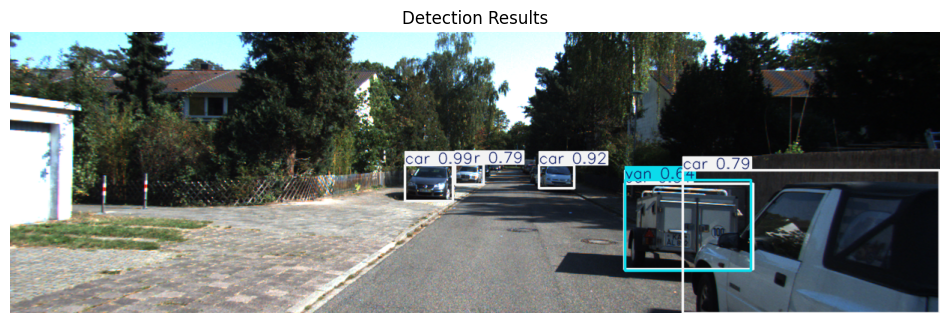

Detected 6 objects:
  1. Class 2: 0.99
  2. Class 2: 0.92
  3. Class 2: 0.79
  4. Class 2: 0.79
  5. Class 81: 0.64
  6. Class 2: 0.51


In [24]:
# Test the model
if model_path and model_path.exists():
    results = test_model_on_image(model_path)
else:
    print("Model not found. Cannot test.")

### Real-time Video Inference

In [25]:
def run_inference_on_video(model_path, video_path=None, output_path=None, conf_threshold=0.25):
    """Run real-time inference on a video file or webcam."""
    # Load the model
    model = YOLO(model_path)

    # Use webcam if video_path is None
    if video_path is None:
        video_path = 0  # Use webcam

    try:
        # Run inference on video
        results = model.predict(source=video_path, conf=conf_threshold, iou=0.45, show=True, save=True)
        print("Video inference completed.")

        # Return the path to the output video (if saved)
        if output_path:
            return output_path
        else:
            return Path(model.predictor.save_dir) / "input_video.mp4"

    except Exception as e:
        print(f"Error running video inference: {e}")
        return None

In [43]:
# Upload a video for inference
from google.colab import files

print("Upload a video file for inference (MP4, MOV, AVI formats supported)")
uploaded = files.upload()

if uploaded:
    # Get the uploaded file path
    video_path = list(uploaded.keys())[0]
    print(f"Running inference on uploaded video: {video_path}")

    # Run inference
    output_video = run_inference_on_video(model_path or 'yolo11n.pt', video_path)

    # Download the result
    if output_video and output_video.exists():
        files.download(str(output_video))
else:
    print("No video uploaded. Skipping video inference.")

Upload a video file for inference (MP4, MOV, AVI formats supported)


Saving 91 Freeway Looking Towards West.mp4 to 91 Freeway Looking Towards West.mp4
Running inference on uploaded video: 91 Freeway Looking Towards West.mp4
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/879) /content/91 Freeway Looking Towards West.mp4: 384x640 10 cars, 194.3ms
video 1/1 (frame 2/879) /content/91 Freeway Looking Towards West.mp4: 384x640 10 cars, 184.5ms
video 1/1 (frame 3/879) /content/91 F

In [44]:
!du -h --max-depth=1 runs/detect/predict2

129M	runs/detect/predict2


### Evaluating Model Performance

In [27]:
def evaluate_model(model_path):
    """Evaluate model performance on the validation set."""
    model = YOLO(model_path)

    try:
        # Run validation
        metrics = model.val(data=str(PROCESSED_DIR / 'data.yaml'))

        # Print metrics
        print("\nValidation Results:")
        print(f"mAP50: {metrics.box.map50:.4f}")
        print(f"mAP50-95: {metrics.box.map:.4f}")
        print(f"Precision: {metrics.box.p:.4f}")
        print(f"Recall: {metrics.box.r:.4f}")

        # Print per-class metrics
        print("\nPer-class Results:")
        for i, ap in enumerate(metrics.box.ap_per_class):
            cls = model.names[i]
            print(f"Class {i} ({cls}): AP50 = {ap:.4f}")

        return metrics
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return None

In [28]:
# Run model evaluation
if model_path and model_path.exists():
    metrics = evaluate_model(model_path)
else:
    print("Model not found. Cannot evaluate.")

Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1896.5±397.1 MB/s, size: 783.9 KB)


val: Scanning /content/datasets/processed/val/labels.cache... 1487 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1487/1487 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [02:19<00:00,  1.50s/it]


                   all       1487       7907      0.339      0.231      0.214      0.122
                person        369        933      0.443      0.581      0.507      0.244
                   car       1341       5522       0.45      0.827      0.749      0.459
                 truck        210        225      0.297     0.0933      0.141     0.0932
               cyclist        232        333      0.188     0.0781     0.0525     0.0224
                   van        426        570       0.31      0.246      0.172      0.113
        person_sitting         20         40          0          0    0.00105   0.000553
                  tram         71        105          1     0.0184     0.0856     0.0455
                  misc        147        179      0.026    0.00559    0.00469    0.00246
Speed: 0.6ms preprocess, 73.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val

Validation Results:
mAP50: 0.2142
mAP50-95: 0.1225
Error during evaluation: unsupp

In [34]:
fps_model_path = "/content/ml_models/best.pt"
fps_image_dir = "/content/datasets/processed/val/images"
num_images = 100
img_size = 640

model = YOLO(fps_model_path)

# === LOAD IMAGES ===
image_files = sorted(Path(fps_image_dir).glob("*.png"))[:num_images]
if not image_files:
    print("❌ No images found!")
else:
    print(f"Running FPS test on {len(image_files)} images...")

    # === START TIMER ===
    start_time = time.time()

    for img_path in image_files:
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        # Run inference (no plotting or verbose output)
        _ = model.predict(img, imgsz=img_size, device='cpu', verbose=False)

    # === END TIMER ===
    end_time = time.time()
    total_time = end_time - start_time
    fps = len(image_files) / total_time

    # === OUTPUT ===
    print(f"\nFPS Test Completed:")
    print(f"Processed {len(image_files)} images in {total_time:.2f} seconds")
    print(f"Inference Speed: {fps:.2f} FPS")


Running FPS test on 100 images...

FPS Test Completed:
Processed 100 images in 10.61 seconds
Inference Speed: 9.42 FPS


Is 9.42 FPS Good?<br>
On CPU (Colab default):<br>
Yes, this is quite good.<br>
Most YOLO models run around 2–10 FPS on CPU, depending on size and resolution.<br>
<br>
For real-time autonomous driving:<br>
❌ Not sufficient. You need ≥20 FPS for safety-critical responsiveness.<br>

### Visualizing the Training Results

In [35]:
def plot_training_results(results_dir):
    """Plot training results from the training directory."""
    try:
        # Find the results.csv
        results_csv = list(Path(results_dir).glob("**/results.csv"))
        if not results_csv:
            print(f"No results.csv found in {results_dir}")
            return None

        results_path = results_csv[0]
        print(f"Loading results from {results_path}")

        # Load the results
        import pandas as pd
        results_df = pd.read_csv(results_path)

        # Plot training metrics
        metrics = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
        fig, ax = plt.subplots(2, 2, figsize=(15, 10))
        ax = ax.flatten()

        for i, metric in enumerate(metrics):
            if metric in results_df.columns:
                ax[i].plot(results_df['epoch'], results_df[metric])
                ax[i].set_title(metric)
                ax[i].set_xlabel('Epoch')
                ax[i].grid(True)
            else:
                print(f"Metric {metric} not found in results.")

        fig.tight_layout()
        plt.show()

        # Plot loss curves
        loss_cols = [col for col in results_df.columns if 'loss' in col]
        if loss_cols:
            plt.figure(figsize=(12, 6))
            for col in loss_cols:
                plt.plot(results_df['epoch'], results_df[col], label=col)
            plt.title('Training Losses')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

        return results_df
    except Exception as e:
        print(f"Error plotting training results: {e}")
        return None

Loading results from /content/runs/train/yolov11_kitti_demo/results.csv


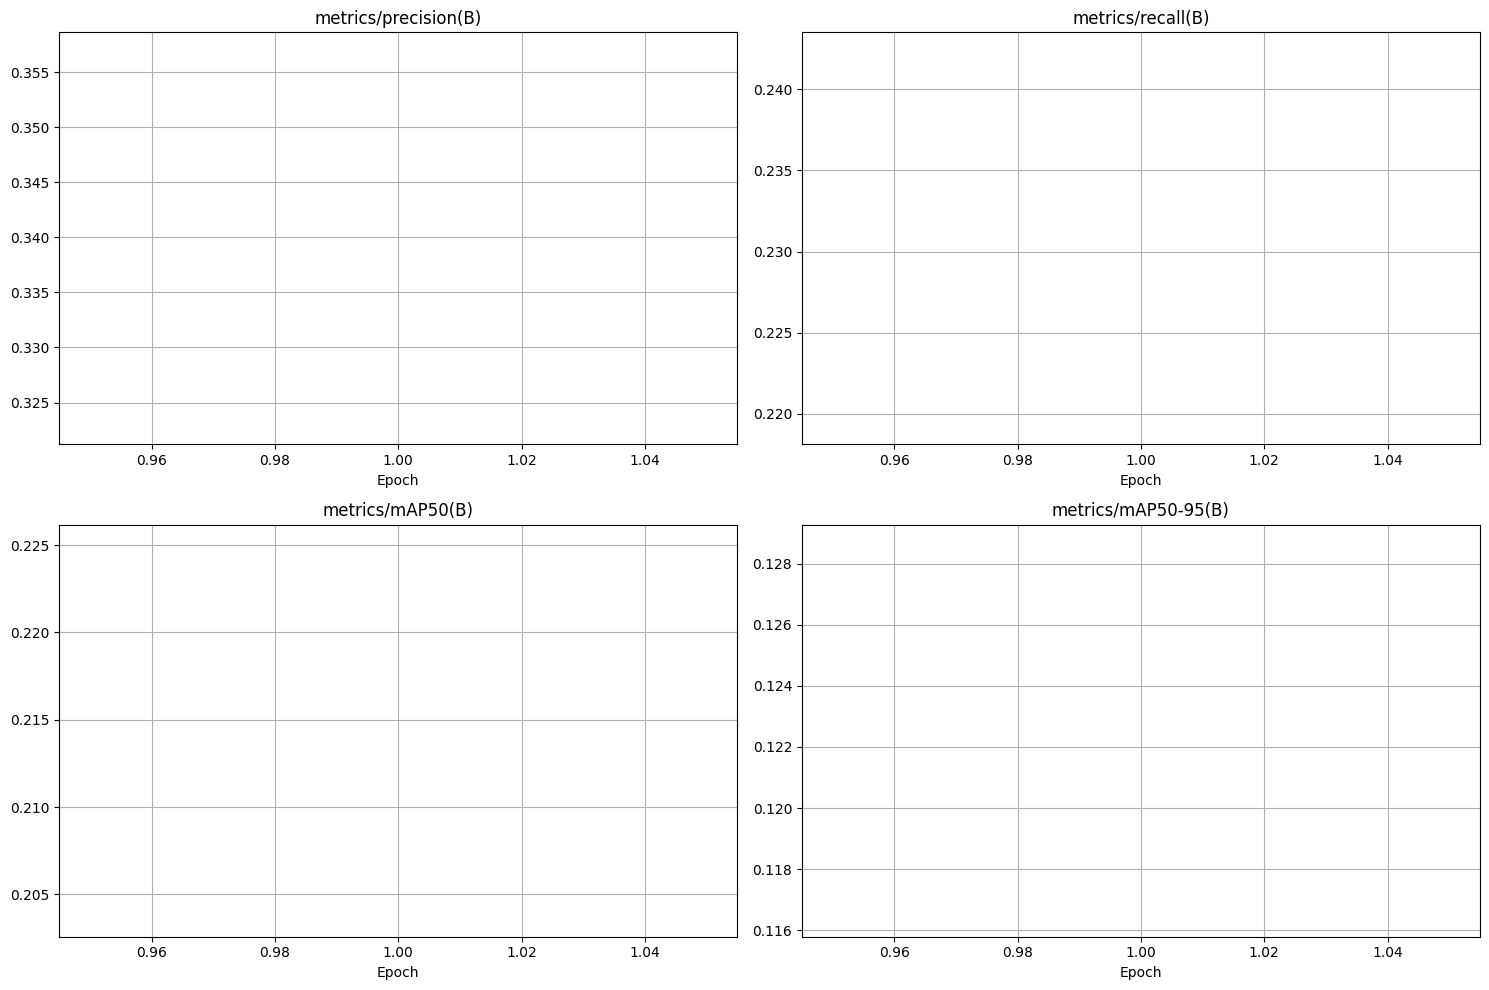

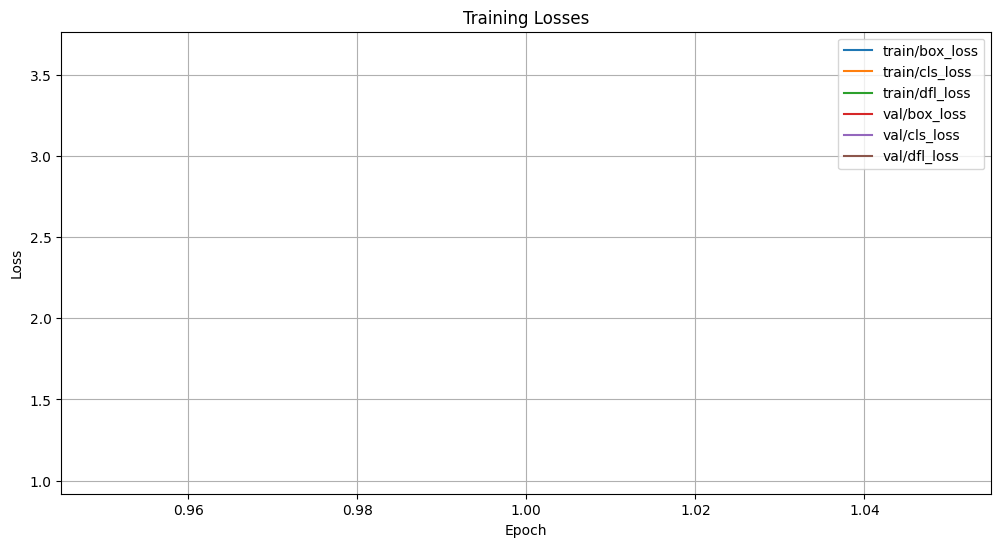

In [36]:
# Plot training results
train_dir = list(Path(RUNS_DIR / 'train').glob(f"*{train_config['name']}*"))
if train_dir:
    results_df = plot_training_results(train_dir[0])
else:
    print("No training results directory found.")

### Analyze Class Distribution

In [37]:
def analyze_class_distribution(processed_dir=PROCESSED_DIR):
    """Analyze the distribution of classes in the dataset."""
    try:
        class_counts = {}
        total_images = 0

        # Load the data.yaml to get class names
        with open(processed_dir / 'data.yaml', 'r') as f:
            data_config = yaml.safe_load(f)
            class_names = data_config['names']

        # Process train and val labels
        for split in ['train', 'val']:
            label_dir = processed_dir / split / 'labels'
            if not label_dir.exists():
                continue

            for label_file in label_dir.glob('*.txt'):
                total_images += 1

                with open(label_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if parts:
                            class_id = int(parts[0])
                            class_name = class_names[class_id] if class_id < len(class_names) else f"Unknown_{class_id}"

                            if class_name in class_counts:
                                class_counts[class_name] += 1
                            else:
                                class_counts[class_name] = 1

        # Sort by count
        sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

        print(f"Total images: {total_images}")
        print(f"Total classes represented: {len(class_counts)}")
        print("\nClass distribution:")

        # Plot the distribution
        plt.figure(figsize=(12, 8))

        # Only plot classes that actually appear in the dataset
        labels = [f"{name} ({count})" for name, count in sorted_counts if count > 0]
        counts = [count for _, count in sorted_counts if count > 0]

        plt.bar(range(len(counts)), counts)
        plt.xticks(range(len(counts)), labels, rotation=90)
        plt.title('Class Distribution in Dataset')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.grid(axis='y')
        plt.show()

        return class_counts

    except Exception as e:
        print(f"Error analyzing class distribution: {e}")
        return None

Total images: 7480
Total classes represented: 8

Class distribution:


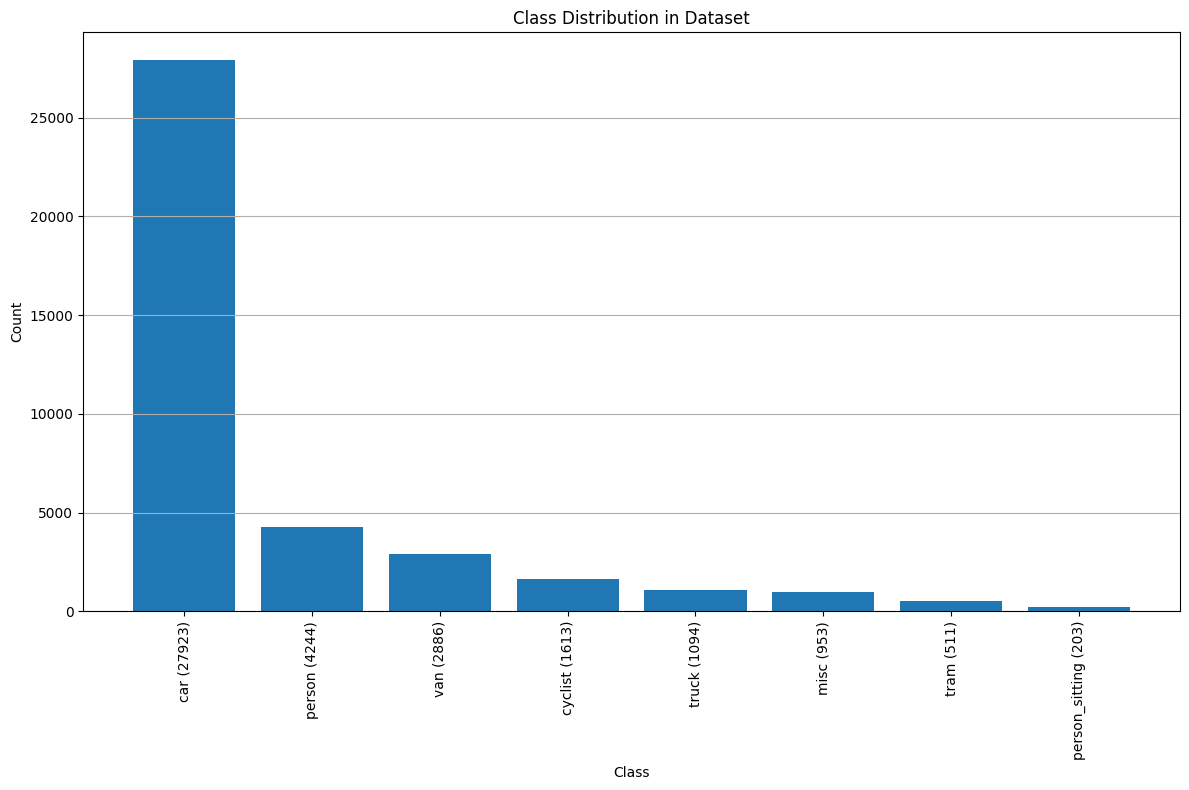

In [38]:
# Analyze class distribution in the dataset
class_counts = analyze_class_distribution()

### Summary and Next Steps

In [39]:
def print_summary():
    """Print a summary of the entire pipeline process."""
    print("\n" + "="*50)
    print("OBJECT DETECTION PIPELINE SUMMARY")
    print("="*50)

    # Check if dataset was processed successfully
    if (PROCESSED_DIR / 'data.yaml').exists():
        print("✅ Dataset preparation: Complete")

        # Count images
        train_imgs = len(list((PROCESSED_DIR / 'train' / 'images').glob('*.png'))) + len(list((PROCESSED_DIR / 'train' / 'images').glob('*.jpg')))
        val_imgs = len(list((PROCESSED_DIR / 'val' / 'images').glob('*.png'))) + len(list((PROCESSED_DIR / 'val' / 'images').glob('*.jpg')))
        print(f"   - Training images: {train_imgs}")
        print(f"   - Validation images: {val_imgs}")
    else:
        print("❌ Dataset preparation: Failed")

    # Check if model was trained successfully
    if (MODELS_DIR / 'best.pt').exists():
        print("✅ Model training: Complete")
        model_size = (MODELS_DIR / 'best.pt').stat().st_size / (1024 * 1024)
        print(f"   - Model size: {model_size:.2f} MB")
    else:
        print("❌ Model training: Failed or incomplete")

    # Check if ONNX export was successful
    if (MODELS_DIR / 'best.onnx').exists():
        print("✅ ONNX export: Complete")
        onnx_size = (MODELS_DIR / 'best.onnx').stat().st_size / (1024 * 1024)
        print(f"   - ONNX model size: {onnx_size:.2f} MB")
    else:
        print("❌ ONNX export: Failed or incomplete")

    # Print next steps
    print("\nNext Steps:")
    print("1. Download the trained model (best.pt) for deployment")
    print("2. For real-time inference, use the ONNX model with a TensorRT engine")
    print("3. For further improvements, consider:")
    print("   - Training for more epochs")
    print("   - Adding more diverse data")
    print("   - Fine-tuning hyperparameters")

    print("\nModel can be used for detection with:")
    print("model = YOLO('best.pt')")
    print("results = model.predict('your_image.jpg')")

In [40]:
# Print summary
print_summary()


OBJECT DETECTION PIPELINE SUMMARY
✅ Dataset preparation: Complete
   - Training images: 5993
   - Validation images: 1487
✅ Model training: Complete
   - Model size: 5.26 MB
✅ ONNX export: Complete
   - ONNX model size: 10.25 MB

Next Steps:
1. Download the trained model (best.pt) for deployment
2. For real-time inference, use the ONNX model with a TensorRT engine
3. For further improvements, consider:
   - Training for more epochs
   - Adding more diverse data
   - Fine-tuning hyperparameters

Model can be used for detection with:
model = YOLO('best.pt')
results = model.predict('your_image.jpg')


In [42]:
# Download trained models for later use
from google.colab import files

# Download the PyTorch model
if (MODELS_DIR / 'best.pt').exists():
    files.download(str(MODELS_DIR / 'best.pt'))
else:
    print("Trained model doesn't exist.")

# Download the ONNX model
if (MODELS_DIR / 'best.onnx').exists():
    files.download(str(MODELS_DIR / 'best.onnx'))
else:
    print("ONNX model doesn't exist.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>